<h2>Notebook for extracting the features of the satellite images using the now fine tuned models

In [3]:
import os
import shutil
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import pickle
import PIL
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
import re
import random
import torch.optim as optim
import numpy as np
from torchvision import models, transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor

Constants defining the paths of the models. This is how they were stored in my file system.

In [4]:
PATH_VGG = "VGG_FINAL\\best_model_2_accuracy=0.6667.pt"
PATH_VIT = 'Vit_REAL\\best_model_7_accuracy=0.9063.pt'
PATH_RESNET = 'res_FINAL\\best_model_6_accuracy=0.8953.pt'
PATH_EFFICIENTNET = 'efficient_FINAL\\best_model_7_accuracy=0.8973.pt'
PATH_SWIN = 'swin_FINAL\\best_model_6_accuracy=0.9007.pt'

Loading the fine tuned VGG Model, making sure it is eval mode 

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg_model = models.vgg13(weights=models.VGG13_Weights.IMAGENET1K_V1)
classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=4096, out_features=384),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=384, out_features=3)
)
vgg_model.classifier = classifier
vgg_model.load_state_dict(torch.load(PATH_VGG))
vgg_model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): 

Loeading Vision Transformer model

In [5]:

VIT_model = models.vit_b_16(weights='DEFAULT')
# classifier2 = nn.Sequential(nn.Linear(in_features=768, out_features=3))

classifier2 = nn.Sequential(
    nn.Linear(in_features=768, out_features=384),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=384, out_features=384),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=384, out_features=3)
)
VIT_model.heads = classifier2
VIT_model.load_state_dict(torch.load(PATH_VIT))
VIT_model.eval()

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate=none)
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_att

Loading the RESNET model

In [32]:
resnet_model = models.resnet18(weights='DEFAULT')

classifier3 = nn.Sequential(
    nn.Linear(in_features=512, out_features=512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=512, out_features=384),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=384, out_features=3)
)

resnet_model.fc = classifier3
resnet_model.load_state_dict(torch.load(PATH_RESNET))
resnet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Creating a custom dataset so that we can extract all the features from all the data. Note, only validation data is used and not the training data to remove the bias of the model towards the training data

In [33]:
efficient_model = models.efficientnet_b3(weights='DEFAULT')

classifier4 = nn.Sequential(
    nn.Linear(in_features=1536, out_features=768),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=768, out_features=384),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=384, out_features=3)
)


efficient_model.classifier = classifier4
efficient_model.load_state_dict(torch.load(PATH_EFFICIENTNET))
efficient_model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [34]:
swin_model = models.swin_b(weights='DEFAULT')

classifier5 = nn.Sequential(
    nn.Linear(in_features=1024, out_features=512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=512, out_features=512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=512, out_features=3)
)

swin_model.head = classifier5
swin_model.load_state_dict(torch.load(PATH_SWIN))
swin_model.eval()

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttention(
          (qkv): Linear(in_features=128, out_features=384, bias=True)
          (proj): Linear(in_features=128, out_features=128, bias=True)
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU(approximate=none)
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=512, out_features=128, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (1): SwinTransformerBlock(


In [35]:
class ExtractionDataset(Dataset):

    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[index, 0])
        image = np.array(PIL.Image.open(img_path).convert('RGB'))        
        if self.transform:
            image = self.transform(image)
        return image, -1

Reading in the annotations of the model and storing the names of the images

In [55]:
annotations = pd.read_csv('val_annotations3.csv')
img_names = [os.path.join('val_bangladesh', i) for i in annotations['image name']]

Loading the data in using the custom dataset and a dataloder. The data is normalized using the same mean and standard deviation previously used when trainin the model to remain consistent.

In [56]:
mean = [0.3560, 0.3692, 0.3417]
std = [0.2059, 0.1733, 0.1620]

tfs_training = transforms.Compose(
        [
            transforms.ToTensor(), 
            transforms.Normalize(mean=mean, std=std),
            transforms.Resize(224)

        ]
    )
not_normal_dataset = ExtractionDataset(annotations_file='val_annotations3.csv', img_dir='all_images_final', transform=tfs_training)
val_dataloader = DataLoader(dataset=not_normal_dataset, batch_size=1, shuffle=False, num_workers=0)
val_data = pd.read_csv('val_annotations3.csv')


In [57]:
pd.read_csv('val_annotations3.csv')

image name  nightlight bins
0         image0_cluster1.png                0
1         image1_cluster1.png                0
2         image2_cluster1.png                0
3         image3_cluster1.png                0
4         image4_cluster1.png                0
...                       ...              ...
10747  image11_cluster675.png                1
10748  image12_cluster675.png                0
10749  image13_cluster675.png                0
10750  image14_cluster675.png                0
10751  image15_cluster675.png                0

[10752 rows x 2 columns]

Finding out the name of the layer from which we will extract the features for each of the models. It is usually the second last layer in each of them as shown in the train nodes function.

In [58]:
train_nodes, eval_nodes = get_graph_node_names(swin_model)
assert(train_nodes==eval_nodes)
print(train_nodes)

# train_nodes, eval_nodes = get_graph_node_names(VIT_model)
# assert(train_nodes==eval_nodes)
# print(train_nodes)

# train_nodes, eval_nodes = get_graph_node_names(resnet_model)
# assert(train_nodes==eval_nodes)
# print(train_nodes)

['x', 'features.0.0', 'features.0.1', 'features.0.2', 'features.1.0.norm1', 'features.1.0.attn.features_1_0_attn_relative_position_bias_table', 'features.1.0.attn.getitem', 'features.1.0.attn.view', 'features.1.0.attn.permute', 'features.1.0.attn.contiguous', 'features.1.0.attn.unsqueeze', 'features.1.0.attn.features_1_0_attn_qkv_weight', 'features.1.0.attn.features_1_0_attn_proj_weight', 'features.1.0.attn.features_1_0_attn_qkv_bias', 'features.1.0.attn.features_1_0_attn_proj_bias', 'features.1.0.attn.shifted_window_attention', 'features.1.0.stochastic_depth', 'features.1.0.add', 'features.1.0.norm2', 'features.1.0.mlp', 'features.1.0.stochastic_depth_1', 'features.1.0.add_1', 'features.1.1.norm1', 'features.1.1.attn.features_1_1_attn_relative_position_bias_table', 'features.1.1.attn.getitem', 'features.1.1.attn.view', 'features.1.1.attn.permute', 'features.1.1.attn.contiguous', 'features.1.1.attn.unsqueeze', 'features.1.1.attn.features_1_1_attn_qkv_weight', 'features.1.1.attn.feature

Code to extract features. This code will make a folder, and in the folder the features for each cluster will be stored in separate folders. 

In [61]:
features_for_classification = ['classifier.4']

feat_extractor = create_feature_extractor(vgg_model, return_nodes=features_for_classification)

image_features = {}
for index, (inputs, _) in enumerate(val_dataloader):
    with torch.no_grad():
        outputs = feat_extractor(inputs) 
        image_features[val_data['image name'][index]] = outputs
image_features_copy = image_features.copy()

for i in image_features_copy.keys():
    image_features_copy[i] = image_features_copy[i]['classifier.4']

image_features_by_cluster = {}
for i in image_features_copy.keys():
    cluster_number = re.search(r'cluster[0-9]+', i)[0][7:]
    cluster_number = int(cluster_number)
    if cluster_number not in image_features_by_cluster.keys():
        image_features_by_cluster[cluster_number] = [image_features_copy[i]]
    else:
        image_features_by_cluster[cluster_number].append(image_features_copy[i])

aggregated_features_by_cluster = {}
for i in image_features_by_cluster.keys():
    aggregated_features_by_cluster[i] = torch.mean(torch.cat(image_features_by_cluster[i]), 0)

os.mkdir('cluster_features_vgg_ban')
for i in aggregated_features_by_cluster.keys(): 
    path = os.path.join('cluster_features_vgg_ban', str(i))
    os.mkdir(path) 
    torch.save(aggregated_features_by_cluster[i], os.path.join(path, f"{i}.pt"))

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
24
24
24
24
24
24
24
24
24
24
24
24
24
2

Feature extraction for VIT model

In [63]:
features_for_classification_VIT = ['heads.4']

feat_extractor = create_feature_extractor(VIT_model, return_nodes=features_for_classification_VIT)

image_features = {}
for index, (inputs, _) in enumerate(val_dataloader):
    with torch.no_grad():
        outputs = feat_extractor(inputs) 
        image_features[val_data['image name'][index]] = outputs
        
image_features_copy = image_features.copy()

for i in image_features_copy.keys():
    image_features_copy[i] = image_features_copy[i]['heads.4']

image_features_by_cluster = {}
for i in image_features_copy.keys():
    cluster_number = re.search(r'cluster[0-9]+', i)[0][7:]
    cluster_number = int(cluster_number)
    if cluster_number not in image_features_by_cluster.keys():
        image_features_by_cluster[cluster_number] = [image_features_copy[i]]
    else:
        image_features_by_cluster[cluster_number].append(image_features_copy[i])

aggregated_features_by_cluster = {}
for i in image_features_by_cluster.keys():
    aggregated_features_by_cluster[i] = torch.mean(torch.cat(image_features_by_cluster[i]), 0)

os.mkdir('cluster_features_vit_ban')
for i in aggregated_features_by_cluster.keys():
    path = os.path.join('cluster_features_vit_ban', str(i))
    os.mkdir(path) 
    torch.save(aggregated_features_by_cluster[i], os.path.join(path, f"{i}.pt"))

Feature extraction for RESNET model

In [59]:
features_for_classification_resnet = ['fc.4']

feat_extractor = create_feature_extractor(resnet_model, return_nodes=features_for_classification_resnet)

image_features = {}
for index, (inputs, _) in enumerate(val_dataloader):
    with torch.no_grad():
        outputs = feat_extractor(inputs) 
        image_features[val_data['image name'][index]] = outputs
        
image_features_copy = image_features.copy()

for i in image_features_copy.keys():
    image_features_copy[i] = image_features_copy[i]['fc.4']

image_features_by_cluster = {}
for i in image_features_copy.keys():
    cluster_number = re.search(r'cluster[0-9]+', i)[0][7:]
    cluster_number = int(cluster_number)
    if cluster_number not in image_features_by_cluster.keys():
        image_features_by_cluster[cluster_number] = [image_features_copy[i]]
    else:
        image_features_by_cluster[cluster_number].append(image_features_copy[i])

aggregated_features_by_cluster = {}
for i in image_features_by_cluster.keys():
    aggregated_features_by_cluster[i] = torch.mean(torch.cat(image_features_by_cluster[i]), 0)

os.mkdir('cluster_features_resnet_ban')
for i in aggregated_features_by_cluster.keys():
    path = os.path.join('cluster_features_resnet_ban', str(i))
    os.mkdir(path) 
    torch.save(aggregated_features_by_cluster[i], os.path.join(path, f"{i}.pt"))

In [43]:
features_for_classification_efficientnet = ['classifier.4']

feat_extractor = create_feature_extractor(efficient_model, return_nodes=features_for_classification_efficientnet)

image_features = {}
for index, (inputs, _) in enumerate(val_dataloader):
    with torch.no_grad():
        outputs = feat_extractor(inputs) 
        image_features[val_data['image name'][index]] = outputs
        
image_features_copy = image_features.copy()

for i in image_features_copy.keys():
    image_features_copy[i] = image_features_copy[i]['classifier.4']

image_features_by_cluster = {}
for i in image_features_copy.keys():
    cluster_number = re.search(r'cluster[0-9]+', i)[0][7:]
    cluster_number = int(cluster_number)
    if cluster_number not in image_features_by_cluster.keys():
        image_features_by_cluster[cluster_number] = [image_features_copy[i]]
    else:
        image_features_by_cluster[cluster_number].append(image_features_copy[i])

aggregated_features_by_cluster = {}
for i in image_features_by_cluster.keys():
    aggregated_features_by_cluster[i] = torch.mean(torch.cat(image_features_by_cluster[i]), 0)

os.mkdir('cluster_features_efficientnet_ban')
for i in aggregated_features_by_cluster.keys():
    path = os.path.join('cluster_features_efficientnet_ban', str(i))
    os.mkdir(path) 
    torch.save(aggregated_features_by_cluster[i], os.path.join(path, f"{i}.pt"))

In [64]:
features_for_classification_swin = ['head.4']

feat_extractor = create_feature_extractor(swin_model, return_nodes=features_for_classification_swin)

image_features = {}
for index, (inputs, _) in enumerate(val_dataloader):
    with torch.no_grad():
        outputs = feat_extractor(inputs) 
        image_features[val_data['image name'][index]] = outputs
        
image_features_copy = image_features.copy()

for i in image_features_copy.keys():
    image_features_copy[i] = image_features_copy[i]['head.4']

image_features_by_cluster = {}
for i in image_features_copy.keys():
    cluster_number = re.search(r'cluster[0-9]+', i)[0][7:]
    cluster_number = int(cluster_number)
    if cluster_number not in image_features_by_cluster.keys():
        image_features_by_cluster[cluster_number] = [image_features_copy[i]]
    else:
        image_features_by_cluster[cluster_number].append(image_features_copy[i])

aggregated_features_by_cluster = {}
for i in image_features_by_cluster.keys():
    aggregated_features_by_cluster[i] = torch.mean(torch.cat(image_features_by_cluster[i]), 0)

os.mkdir('cluster_features_swin_ban')
for i in aggregated_features_by_cluster.keys():
    path = os.path.join('cluster_features_swin_ban', str(i))
    os.mkdir(path) 
    torch.save(aggregated_features_by_cluster[i], os.path.join(path, f"{i}.pt"))

In [156]:
196/14

14.0

In [11]:
mean = [0.3797, 0.3828, 0.3630]
std = [0.2064, 0.1764, 0.1651]

tfs_training = transforms.Compose(
        [
            transforms.ToTensor(), 
            transforms.Normalize(mean=mean, std=std),
            transforms.Resize(224)

        ]
    )
feature_map_dataset = ExtractionDataset(annotations_file='test_annotations.csv', img_dir='feature_maps', transform=tfs_training)
feature_map_loader = DataLoader(dataset=feature_map_dataset, batch_size=1, shuffle=False, num_workers=0)
a = []
for i in feature_map_loader:
    a.append(i[0])

In [167]:

train_nodes, eval_nodes = get_graph_node_names(vgg_model)
train_nodes

['x',
 'features.0',
 'features.1',
 'features.2',
 'features.3',
 'features.4',
 'features.5',
 'features.6',
 'features.7',
 'features.8',
 'features.9',
 'features.10',
 'features.11',
 'features.12',
 'features.13',
 'features.14',
 'features.15',
 'features.16',
 'features.17',
 'features.18',
 'features.19',
 'features.20',
 'features.21',
 'features.22',
 'features.23',
 'features.24',
 'avgpool',
 'flatten',
 'classifier.0',
 'classifier.1',
 'classifier.2',
 'classifier.3',
 'classifier.4',
 'classifier.5',
 'classifier.6']

Code to vizualize feature maps from a model. 

In [343]:
indexing_order = [0,2,1,3,5,4]
titles = ['High Nightlight', 'Medium Nightlight', 'Low Nightlight', 'High Nightlight', 'Medium Nightlight', 'Low Nightlight']

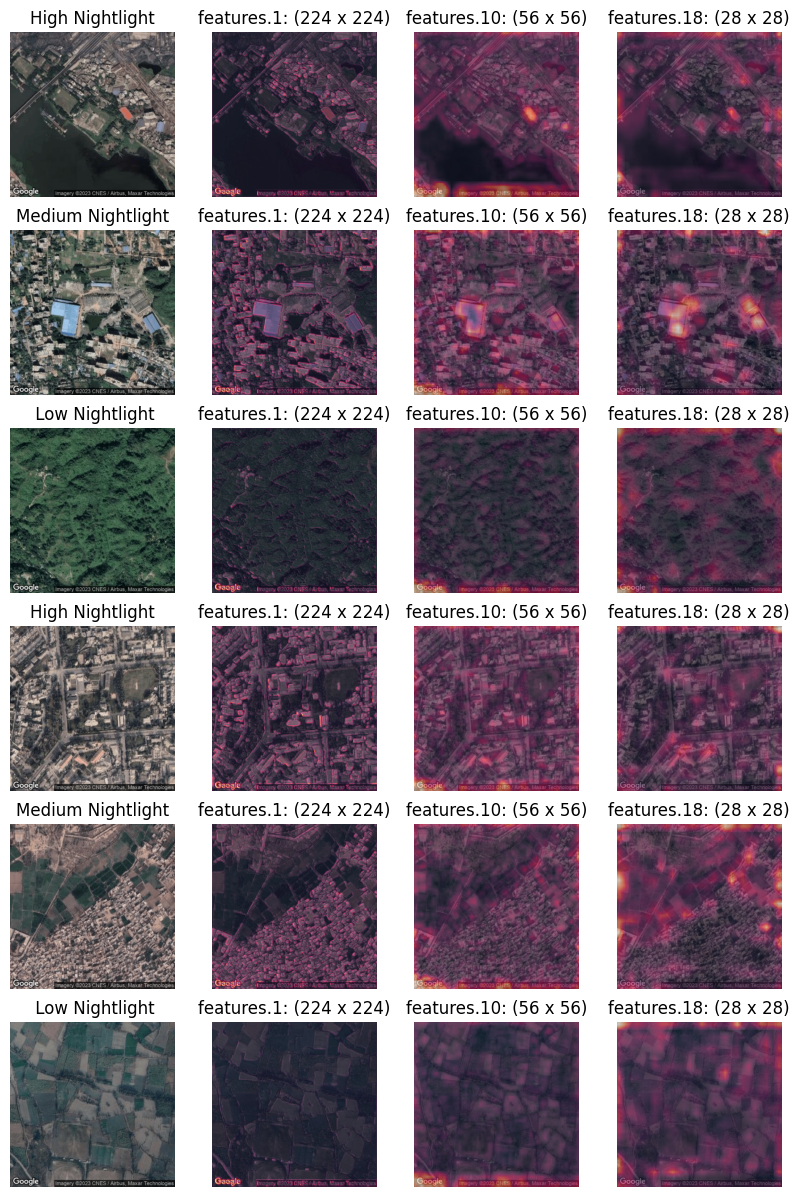

In [326]:
MODEL = vgg_model

fig, ax = plt.subplots(6, 4, figsize=(10, 15))
for imgn in range(6):
    return_nodes = ['features.1', 'features.10', 'features.18']
    view_features = create_feature_extractor(MODEL, return_nodes=return_nodes)
    feature_map_annotations = pd.read_csv('test_annotations.csv')
    img_path = os.path.join('feature_maps', feature_map_annotations.iloc[indexing_order[imgn], 0])
    image = np.array(PIL.Image.open(img_path).convert('RGB'))  
    with torch.no_grad(): 
        out = view_features(a[indexing_order[imgn]]) 
    ax[imgn][0].imshow(image)
    ax[imgn][0].set_title(titles[imgn])

    for i, layer in enumerate(return_nodes, start=1):
        feat_maps = out[layer].squeeze(0)
        feat_map = feat_maps.mean(dim=0)
        shape = feat_map.shape
        feat_map_resized = F.interpolate(feat_map.view(1,1,shape[0], shape[1]), (350, 350), mode='bilinear').view(350, 350)
        sns.heatmap(feat_map_resized, ax=ax[imgn][i], cbar=False, alpha=0.6)
        ax[imgn][i].set_title(f'{layer}: ({feat_map.shape[0]} x {feat_map.shape[1]})')
        ax[imgn][0].set_axis_off()
        ax[imgn][i].set_axis_off()
    ax[imgn][1].imshow(image)
    ax[imgn][2].imshow(image)
    ax[imgn][3].imshow(image)

In [306]:
# return_nodes = ['encoder.layers.encoder_layer_1.mlp']
# view_features = create_feature_extractor(VIT_model, return_nodes=return_nodes)

# feature_map_annotations = pd.read_csv('test_annotations.csv')
# img_path = os.path.join('feature_maps', feature_map_annotations.iloc[0, 0])
# image = np.array(PIL.Image.open(img_path).convert('RGB'))  

# with torch.no_grad(): 
#     out = view_features(a[0]) 
# xx = out['encoder.layers.encoder_layer_1.mlp']
# cls_weight = xx[0, 1:].mean(dim=1).view(14, 14)

# def show_img(img):
#     img = np.asarray(img)
#     plt.figure(figsize=(10, 10))
#     plt.imshow(img)
#     plt.axis('off')
#     plt.show()


# def show_img2(img1, img2, alpha=0.8):
#     img1 = np.asarray(img1)
#     img2 = np.asarray(img2)
#     plt.figure(figsize=(10, 10))
#     plt.imshow(img1)
#     plt.imshow(img2, alpha=alpha)
#     plt.axis('off')
#     plt.show()
# sns.heatmap(cls_weight)

torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


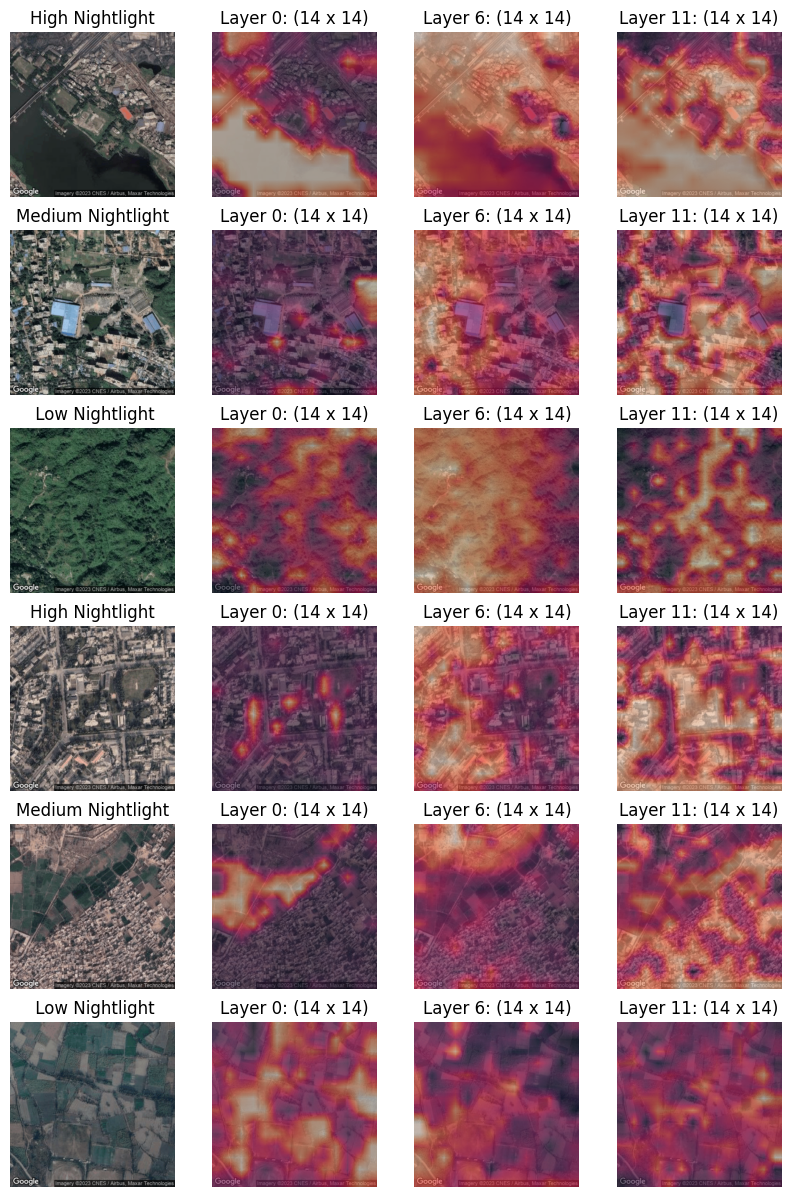

In [333]:
MODEL = VIT_model
return_nodes = ['encoder.layers.encoder_layer_0.getitem', 'encoder.layers.encoder_layer_6.getitem', 'encoder.layers.encoder_layer_11.getitem']
fig, ax = plt.subplots(6, 4, figsize=(10, 15))

for imgn in range(6):
    view_features = create_feature_extractor(MODEL, return_nodes=return_nodes)
    names = ['0', '6', '11']
    feature_map_annotations = pd.read_csv('test_annotations.csv')
    img_path = os.path.join('feature_maps', feature_map_annotations.iloc[indexing_order[imgn], 0])
    image = np.array(PIL.Image.open(img_path).convert('RGB'))  
    with torch.no_grad(): 
        out = view_features(a[indexing_order[imgn]]) 

    ax[imgn][0].imshow(image)
    ax[imgn][0].set_title(titles[imgn])
    for i, layer in enumerate(return_nodes, start=1):
        feat_maps = out[layer]
        print(feat_maps.shape)
        cls_weight = feat_maps[0, 1:].mean(dim=1).view(14, 14)
        cls_resized = F.interpolate(cls_weight.view(1, 1, 14, 14), (350, 350), mode='bilinear').view(350, 350)
        sns.heatmap(cls_resized, ax=ax[imgn][i], alpha=0.6, cbar=False)
        ax[imgn][i].imshow(image)
        ax[imgn][i].set_title(f'Layer {names[i-1]}: ({cls_weight.shape[0]} x {cls_weight.shape[1]})')
        ax[imgn][0].set_axis_off()
        ax[imgn][i].set_axis_off()

In [361]:
train_nodes, eval_nodes = get_graph_node_names(swin_model)
train_nodes

['x',
 'features.0.0',
 'features.0.1',
 'features.0.2',
 'features.1.0.norm1',
 'features.1.0.attn.features_1_0_attn_relative_position_bias_table',
 'features.1.0.attn.getitem',
 'features.1.0.attn.view',
 'features.1.0.attn.permute',
 'features.1.0.attn.contiguous',
 'features.1.0.attn.unsqueeze',
 'features.1.0.attn.features_1_0_attn_qkv_weight',
 'features.1.0.attn.features_1_0_attn_proj_weight',
 'features.1.0.attn.features_1_0_attn_qkv_bias',
 'features.1.0.attn.features_1_0_attn_proj_bias',
 'features.1.0.attn.shifted_window_attention',
 'features.1.0.stochastic_depth',
 'features.1.0.add',
 'features.1.0.norm2',
 'features.1.0.mlp',
 'features.1.0.stochastic_depth_1',
 'features.1.0.add_1',
 'features.1.1.norm1',
 'features.1.1.attn.features_1_1_attn_relative_position_bias_table',
 'features.1.1.attn.getitem',
 'features.1.1.attn.view',
 'features.1.1.attn.permute',
 'features.1.1.attn.contiguous',
 'features.1.1.attn.unsqueeze',
 'features.1.1.attn.features_1_1_attn_qkv_weight

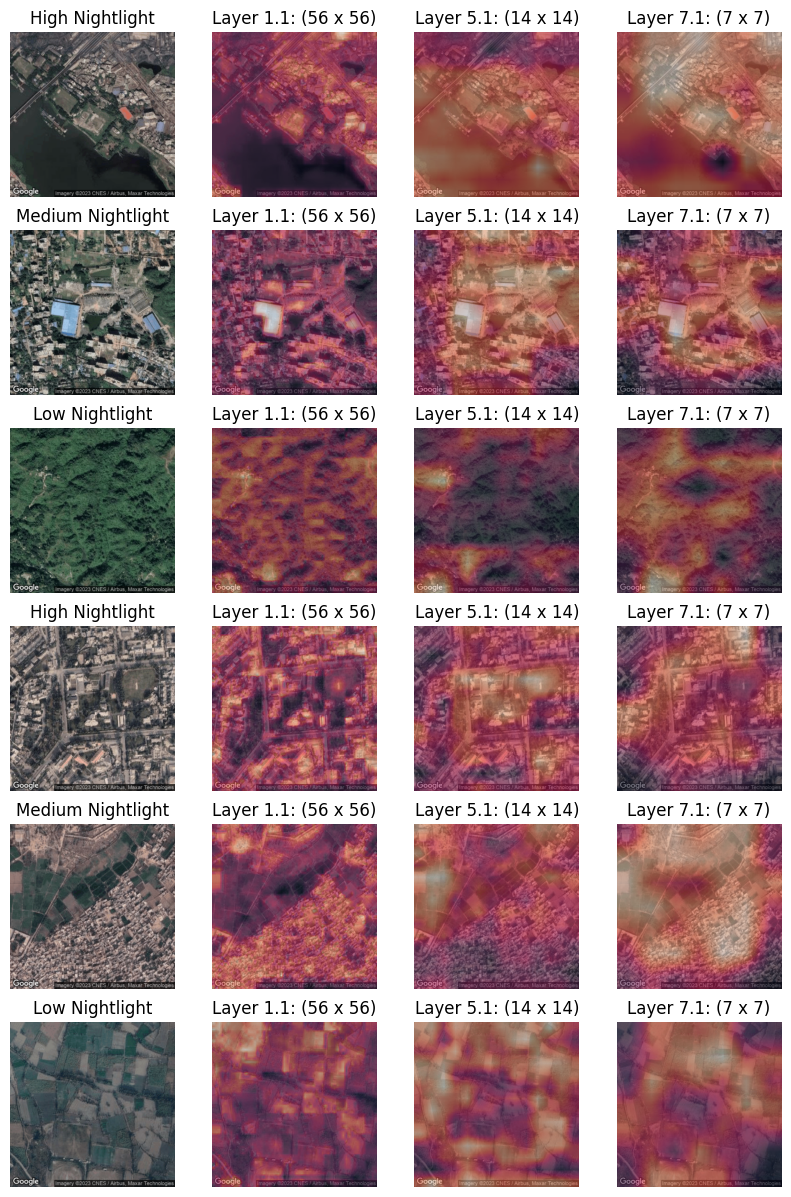

In [362]:
MODEL = swin_model

return_nodes = ['features.1.1.attn.shifted_window_attention', 'features.5.1.attn.shifted_window_attention', 'features.7.0.attn.shifted_window_attention']
fig, ax = plt.subplots(6, 4, figsize=(10, 15))
for imgn in range(6):
    names = ['1.1', '5.1', '7.1']
    view_features = create_feature_extractor(MODEL, return_nodes=return_nodes)

    feature_map_annotations = pd.read_csv('test_annotations.csv')
    img_path = os.path.join('feature_maps', feature_map_annotations.iloc[indexing_order[imgn], 0])
    image = np.array(PIL.Image.open(img_path).convert('RGB'))  
    with torch.no_grad(): 
        out = view_features(a[indexing_order[imgn]]) 

    ax[imgn][0].imshow(image)
    ax[imgn][0].set_title(titles[imgn])

    for i, layer in enumerate(return_nodes, start=1):
        feat_maps = out[layer][0]
        shape = feat_maps.shape
        cls_weight = feat_maps.mean(dim=2).view(shape[0], shape[1]).detach()
        cls_resized = F.interpolate(cls_weight.view(1, 1, shape[0], shape[1]), (350, 350), mode='bilinear').view(350, 350)
        sns.heatmap(cls_resized, ax=ax[imgn][i], alpha=0.5, cbar=False)
        ax[imgn][i].imshow(image)
        ax[imgn][i].set_title(f'Layer {names[i-1]}: ({shape[0]} x {shape[1]})')
        ax[imgn][0].set_axis_off()
        ax[imgn][i].set_axis_off()

In [348]:
train_nodes, eval_nodes = get_graph_node_names(efficient_model)
train_nodes

['x',
 'features.0',
 'features.1.0.block.0',
 'features.1.0.block.1',
 'features.1.0.block.2',
 'features.1.1.block.0',
 'features.1.1.block.1',
 'features.1.1.block.2',
 'features.1.1.stochastic_depth',
 'features.1.1.add',
 'features.2.0.block.0',
 'features.2.0.block.1',
 'features.2.0.block.2',
 'features.2.0.block.3',
 'features.2.1.block.0',
 'features.2.1.block.1',
 'features.2.1.block.2',
 'features.2.1.block.3',
 'features.2.1.stochastic_depth',
 'features.2.1.add',
 'features.2.2.block.0',
 'features.2.2.block.1',
 'features.2.2.block.2',
 'features.2.2.block.3',
 'features.2.2.stochastic_depth',
 'features.2.2.add',
 'features.3.0.block.0',
 'features.3.0.block.1',
 'features.3.0.block.2',
 'features.3.0.block.3',
 'features.3.1.block.0',
 'features.3.1.block.1',
 'features.3.1.block.2',
 'features.3.1.block.3',
 'features.3.1.stochastic_depth',
 'features.3.1.add',
 'features.3.2.block.0',
 'features.3.2.block.1',
 'features.3.2.block.2',
 'features.3.2.block.3',
 'feature

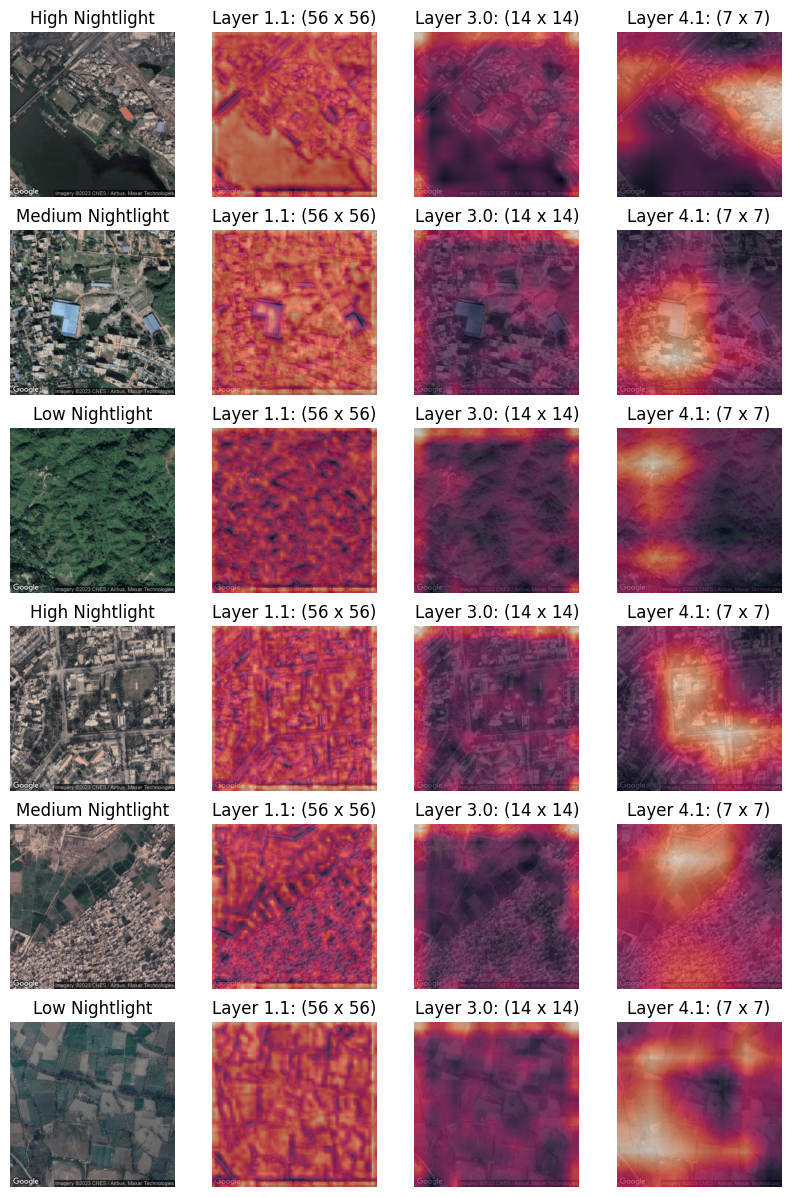

In [347]:
MODEL = resnet_model

return_nodes = ['layer1.1.conv2', 'layer3.0.conv1', 'layer4.1.conv2']
names = ['1.1', '3.0', '4.1']
fig, ax = plt.subplots(6, 4, figsize=(10, 15))
view_features = create_feature_extractor(MODEL, return_nodes=return_nodes)
for imgn in range(6):
    feature_map_annotations = pd.read_csv('test_annotations.csv')
    img_path = os.path.join('feature_maps', feature_map_annotations.iloc[indexing_order[imgn], 0])
    image = np.array(PIL.Image.open(img_path).convert('RGB'))  
    with torch.no_grad(): 
        out = view_features(a[indexing_order[imgn]]) 

    ax[imgn][0].imshow(image)
    ax[imgn][0].set_title(titles[imgn])

    for i, layer in enumerate(return_nodes, start=1):
        feat_maps = out[layer].squeeze(0)
        feat_map = feat_maps.mean(dim=0)
        shape = feat_map.shape
        feat_map_resized = F.interpolate(feat_map.view(1,1,shape[0], shape[1]), (350, 350), mode='bilinear').view(350, 350)
        sns.heatmap(feat_map_resized, ax=ax[imgn][i], cbar=False, alpha=0.7)
        ax[imgn][i].set_title(f'Layer {names[i-1]}: ({feat_map.shape[0]} x {feat_map.shape[1]})')
        ax[imgn][i].imshow(image)
        ax[imgn][0].set_axis_off()
        ax[imgn][i].set_axis_off()


In [349]:
train_nodes, eval_nodes = get_graph_node_names(efficient_model)
train_nodes

['x',
 'features.0',
 'features.1.0.block.0',
 'features.1.0.block.1',
 'features.1.0.block.2',
 'features.1.1.block.0',
 'features.1.1.block.1',
 'features.1.1.block.2',
 'features.1.1.stochastic_depth',
 'features.1.1.add',
 'features.2.0.block.0',
 'features.2.0.block.1',
 'features.2.0.block.2',
 'features.2.0.block.3',
 'features.2.1.block.0',
 'features.2.1.block.1',
 'features.2.1.block.2',
 'features.2.1.block.3',
 'features.2.1.stochastic_depth',
 'features.2.1.add',
 'features.2.2.block.0',
 'features.2.2.block.1',
 'features.2.2.block.2',
 'features.2.2.block.3',
 'features.2.2.stochastic_depth',
 'features.2.2.add',
 'features.3.0.block.0',
 'features.3.0.block.1',
 'features.3.0.block.2',
 'features.3.0.block.3',
 'features.3.1.block.0',
 'features.3.1.block.1',
 'features.3.1.block.2',
 'features.3.1.block.3',
 'features.3.1.stochastic_depth',
 'features.3.1.add',
 'features.3.2.block.0',
 'features.3.2.block.1',
 'features.3.2.block.2',
 'features.3.2.block.3',
 'feature

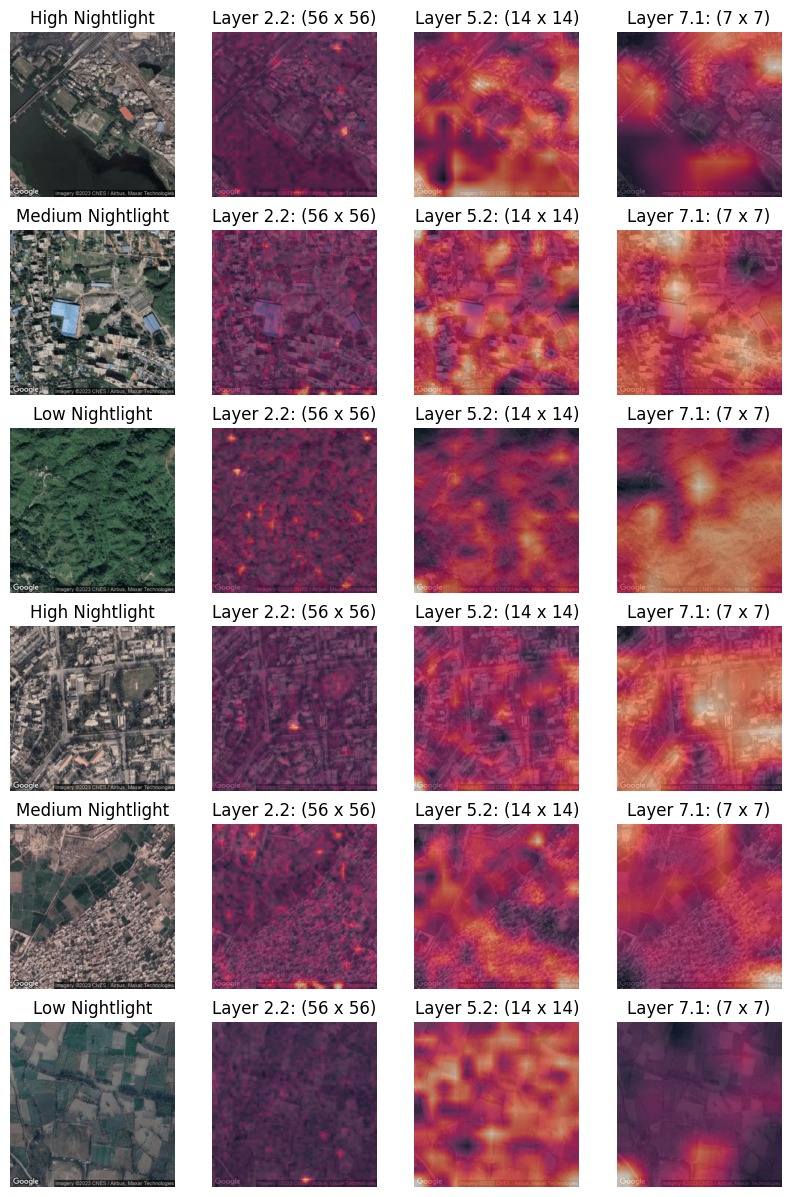

In [360]:
MODEL = efficient_model

return_nodes = [  'features.2.2.block.3',
 'features.5.2.block.3',
 'features.7.1.block.3',
]

fig, ax = plt.subplots(6, 4, figsize=(10, 15))
names = ['2.2', '5.2', '7.1']
view_features = create_feature_extractor(MODEL, return_nodes=return_nodes)
for imgn in range(6):
    feature_map_annotations = pd.read_csv('test_annotations.csv')
    img_path = os.path.join('feature_maps', feature_map_annotations.iloc[indexing_order[imgn], 0])
    image = np.array(PIL.Image.open(img_path).convert('RGB'))  
    with torch.no_grad(): 
        out = view_features(a[indexing_order[imgn]]) 
    ax[imgn][0].imshow(image)
    ax[imgn][0].set_title(titles[imgn])
    with torch.no_grad(): 
        out = view_features(a[imgn]) 
    for i, layer in enumerate(return_nodes, start=1):
        feat_maps = out[layer].squeeze(0)
        feat_map = feat_maps.mean(dim=0)
        shape = feat_map.shape
        feat_map_resized = F.interpolate(feat_map.view(1,1,shape[0], shape[1]), (350, 350), mode='bilinear').view(350, 350)
        ax[imgn][0].imshow(image)
        sns.heatmap(feat_map_resized, ax=ax[imgn][i], cbar=False, alpha=0.7)
        ax[imgn][i].set_title(f'Layer {names[i-1]}: ({feat_map.shape[0]} x {feat_map.shape[1]})')
        ax[imgn][i].imshow(image)
        ax[imgn][0].set_axis_off()
        ax[imgn][i].set_axis_off()
